### **FARADISHA ALDINA PUTRI - 2141720159 - TI 3I**

## **Lab Work 1- RNN for Sentiment Analysis**

**Setup**

Import matplotlib and create a helper function to plot the graph:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

**Setup Input Pipeline**

The IMDB movie review dataset is a binary classification dataset—all reviews have either positive or negative sentiment.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially, this returns a dataset (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next, shuffle the data for training and create this pair dataset:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Farrah Fawcett gives an award nominated performance as an attempted rape victim who turns the tables on her attacker. This movie not only makes you examine your own morals, it proves that Fawcett can excel as a serious actress both as a victim and victor.'
 b'This film was horrible. The script is COMPLETELY unrealistic yet it is written to take place in the real-world, the editing and lighting effects are worse than most first projects in film school.<br /><br />I do not recommend this film to anyone who: A) knows any detail about the world of police or covert operations. B) knows any detail about film making or appreciation.<br /><br />I do recommend this film to the average or below-average mind, I think it would be enjoyable if I was a dumber. If you must watch this film on a full mind, I highly recommend some kind of inebriation<br /><br />It is a total waste of what little production value it has.'
 b"Kind of drawn in by the erotic scenes, only to realize this was one o

**Create a Text Encoder**

Raw text loaded by tfds needs to be processed before it can be used in a model. The easiest way to preprocess text for training is to use the TextVectorization layer. This layer has many capabilities, but in this tutorial, we are using the default behavior. Create this layer and pass the text dataset to the layer's .adapt method:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. The first 20 tokens can be seen with the following code. After padding and unknown tokens, they are sorted by frequency:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The index tensor is padded with 0s to the longest sequence in the batch (unless if you set output_sequence_length fixed):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1, 388, ...,   0,   0,   0],
       [ 11,  20,  14, ...,   0,   0,   0],
       [238,   5,   1, ...,   0,   0,   0]])

With the default settings, the process cannot be fully reversed. There are two main reasons for this:
- The default value for the standardization argument of preprocessing.TextVectorization is "lower_and_strip_punctuation".
- The limited vocabulary size and the lack of character-based fallback result in some unknown tokens.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Farrah Fawcett gives an award nominated performance as an attempted rape victim who turns the tables on her attacker. This movie not only makes you examine your own morals, it proves that Fawcett can excel as a serious actress both as a victim and victor.'
Round-trip:  [UNK] [UNK] gives an [UNK] [UNK] performance as an [UNK] [UNK] [UNK] who turns the [UNK] on her [UNK] this movie not only makes you [UNK] your own [UNK] it [UNK] that [UNK] can [UNK] as a serious actress both as a [UNK] and [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

#### **Create a model**

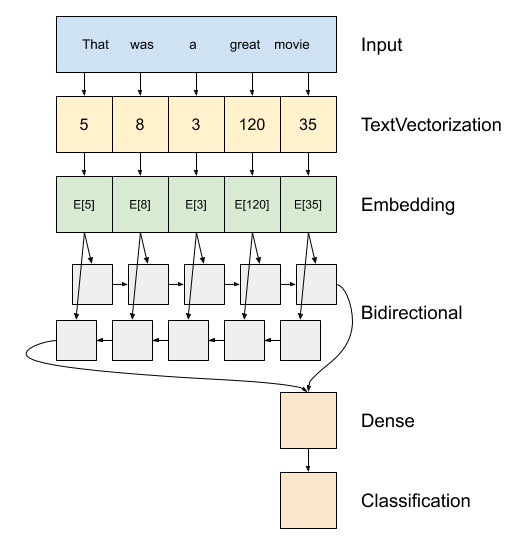

1. This model can be created as tf.keras.Sequential.
2. The first layer is the encoder, which converts text into a sequence of token indices.
3. Following the encoder is the embedding layer. The embedding layer stores one vector per word. When called, it transforms a sequence of word indices into a sequence of vectors. These vectors can be trained. After training (with enough data), words with similar meanings often have similar vectors. This indexing operation is much more efficient than equivalent operations performed on one-hot encoded vectors passed through a tf.keras.layers.Dense layer.
4. The Recurrent Neural Network (RNN) processes the input sequence by iterating through its elements. The RNN passes the output from one time step to its input in the next time step. A tf.keras.layers.Bidirectional wrapper can also be used with the RNN layer. This propagates the input forward and backward through the RNN layer and then combines the final output. The main advantage of bidirectional RNNs is that signals from the beginning of the input do not have to be processed all the way through to affect the output. The main disadvantage of bidirectional RNNs is that you cannot perform efficient streaming predictions as words are added at the end.
5. After the RNN converts the sequence to a single vector, both Dense layers perform some final processing, and convert this vector representation into a single logit as the classification output.

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that a Keras Sequential model is used here because all the layers in the model have a single input and produce a single output. If you want to use stateful RNN layers, you might want to build your model using the Keras functional API or model subclassing so you can capture and reuse the state of RNN layers. For details, you can refer to the Keras RNN guide.

The embedding layer uses masking (uses masking) to handle varying sequence lengths. All layers after the embedding support masking.

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To ensure this works as expected, evaluate a sentence twice. First, a single sentence with no padding to mask:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.01468438]


Now, evaluate again in a batch with longer sentences. The result should be the same:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[-0.01468438]


Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 103ms/step - loss: 0.6498 - accuracy: 0.5534 - val_loss: 0.5294 - val_accuracy: 0.7068
Epoch 2/10
391/391 [==============================] - 25s 65ms/step - loss: 0.4345 - accuracy: 0.7960 - val_loss: 0.3834 - val_accuracy: 0.8328
Epoch 3/10
391/391 [==============================] - 24s 59ms/step - loss: 0.3503 - accuracy: 0.8447 - val_loss: 0.3426 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3248 - accuracy: 0.8592 - val_loss: 0.3403 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3159 - accuracy: 0.8633 - val_loss: 0.3344 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3093 - accuracy: 0.8675 - val_loss: 0.3395 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3074 - accuracy: 0.8677 - val_loss: 0.3231 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 29ms/step - loss: 0.3188 - accuracy: 0.8493
Test Loss: 0.3188062012195587
Test Accuracy: 0.8493199944496155


(0.0, 0.6673040628433228)

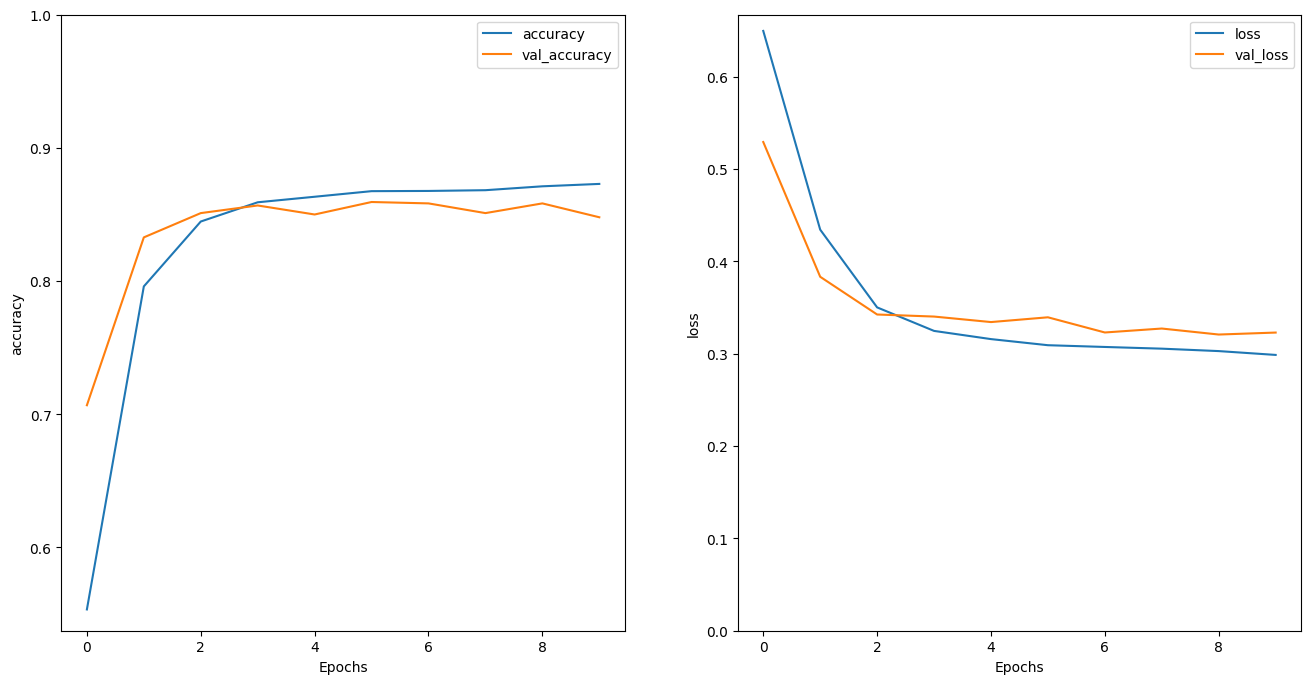

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on a new sentence: If the prediction is >= 0.0, it's positive; otherwise, it's negative.

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


Keras RNN layers have two modes available, which are controlled by the return_sequences constructor argument:

- If False, it only returns the last output for each input sequence (a 2D tensor shape (batch_size, output_features)). This is the default used in the previous model.
- If True, it returns the full sequence of outputs for each time step (a 3D tensor shape (batch_size, time_steps, output_features)).

Here is the information flow with return_sequences=True:

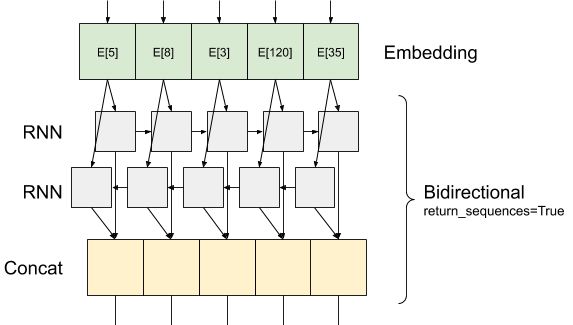

One interesting aspect of using RNNs with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to other RNN layers, like this

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 151ms/step - loss: 0.6534 - accuracy: 0.5608 - val_loss: 0.5339 - val_accuracy: 0.7724
Epoch 2/10
391/391 [==============================] - 45s 114ms/step - loss: 0.4172 - accuracy: 0.8164 - val_loss: 0.3757 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3436 - accuracy: 0.8553 - val_loss: 0.3451 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3209 - accuracy: 0.8624 - val_loss: 0.3279 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3132 - accuracy: 0.8653 - val_loss: 0.3284 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3078 - accuracy: 0.8678 - val_loss: 0.3245 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3072 - accuracy: 0.8693 - val_loss: 0.3259 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 23s 59ms/step - loss: 0.3156 - accuracy: 0.8555
Test Loss: 0.31556078791618347
Test Accuracy: 0.8554800152778625


In [23]:
# predict on a sample text without padding.
# Assuming encoder is your text encoder
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Predict on the preprocessed sample text
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.4601239]]


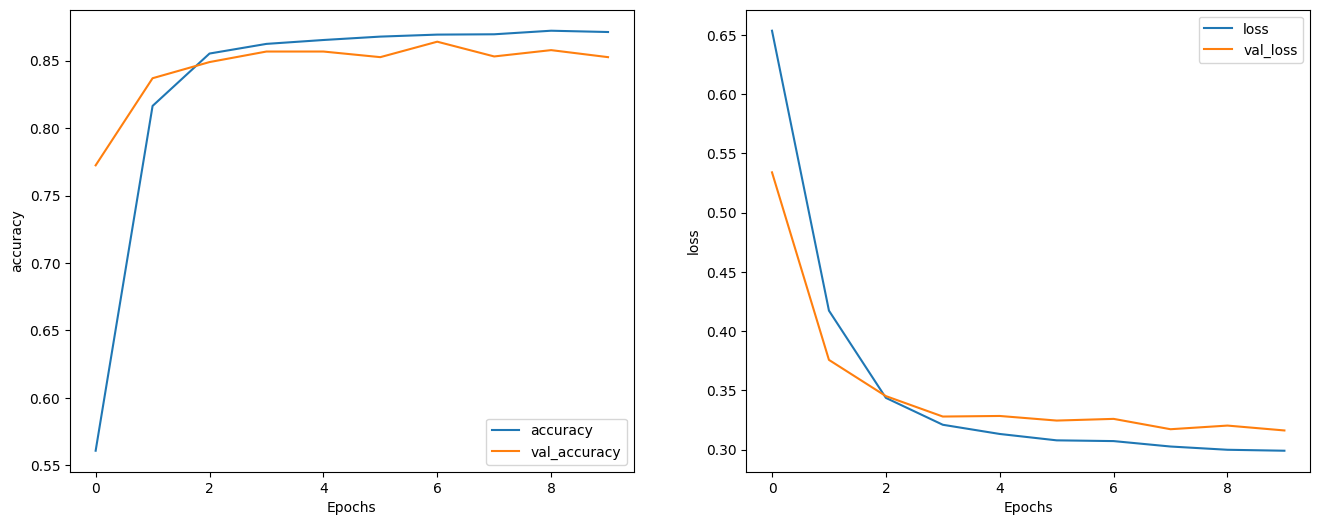

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

---

## **Lab Work 2-Text Generator with RNN**

This lab demonstrates how to perform text generation using an RNN. The dataset used is Shakespeare's writing from Andrej Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks. Given a sequence of characters from this data ('Shakespear'), train a model to predict the next character in the sequence ('e'). Longer text sequences can be generated by repeatedly calling the model.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.

This tutorial uses tf.keras and eager execution. Here is an example output when the model in this tutorial is trained for 30 epochs, starting with the prompt 'Q':

**Setup**

Import TenserFlow

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [28]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [29]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [31]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Text Processing**

Vectorize Text

Before training, you need to convert the string into a numeric representation. tf.keras.layers.StringLookup can convert each character to a numeric ID. The way this is done is by first breaking the text into tokens.

In [32]:

example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the tf.keras.layers.StringLookup layer:

In [33]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [34]:
# The above command converts tokens into IDs.
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it's also important to reverse this representation. For this, you can use the tf.keras.layers.StringLookup(..., invert=True) code.

Note: In this code, instead of passing the original vocabulary generated with sorted(set(text)), use the get_vocabulary() method from tf.keras.layers.StringLookup so that the [UNK] token is set in the same way.

In [35]:

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


This layer converts characters back from the ID vector and returns them as a tf.RaggedTensor:

In [36]:
# This layer converts characters back from the ID vector and returns them as a tf.RaggedTensor:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [37]:
# You can use tf.strings.reduce_join to recombine characters into a string.
result = tf.strings.reduce_join(chars, axis=-1).numpy()

In [38]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediction**


Given a character, or a sequence of characters, what is the most likely next character? This is the task that you need to train the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output as the next character at each time step. Since the RNN maintains an internal state that depends on the elements seen so far, given all the characters computed thus far, what is the next character?

*Creating the Training Set and Target*

Next, divide the text into example sequences. Each input sequence will contain seq_length characters from the text. For each input sequence, the target prediction contains the text with the same length, but shifted one character to the right. So, split the text into seq_length+1 parts. For example, if seq_length is 4 and your text is "Hello," the input sequence is "Hell," and the target sequence is "ello." To do this, first use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

In [39]:
# Convert the text to token IDs using ids_from_chars layer
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
print(all_ids)


tf.Tensor([19 48 57 ... 46  9  1], shape=(1115394,), dtype=int64)


In [40]:

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [41]:

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [42]:

seq_length = 100

In [43]:

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [44]:

for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training, you need a dataset of pairs (input, label), where input and label are sequences. At each time step, the input is the current character, and the label is the next character. Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each time step:

In [45]:

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [46]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [47]:
dataset = sequences.map(split_input_target)

In [48]:

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


*Creating Batch Training*

You use tf.data to divide the text into manageable sequences. However, before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [49]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Create a Model**

This section defines the model as a keras.Model subclass (for more details, see Making new Layers and Models via subclassing).

The model we build has 3 neural network layers:

- tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map each character-ID to a vector with dimension embedding_dim;
- tf.keras.layers.GRU: The RNN layer with a unit size of rnn_units (you can also use an LSTM layer here.)
- tf.keras.layers.Dense: The output layer, with output vocab_size. It generates one logit for each character in the vocabulary. This is the log-likelihood of each character according to the model.

In [50]:

# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [51]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [52]:

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character, the model looks up the embedding, runs the GRU one time step with the embedding as input, and applies the dense layer to produce logits that predict the log-likelihood of the next character:


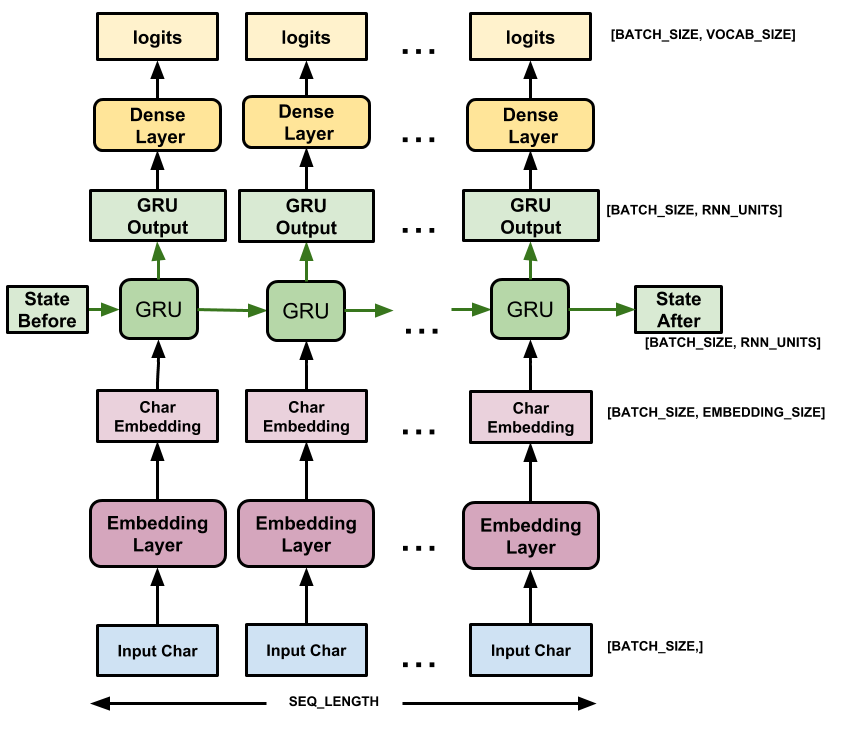

Note: For training, you can use a keras.Sequential model here. To generate text later, you will have to manage the internal RNN state. It is easier to include input and output state options at the beginning, rather than reconfiguring the model architecture later. For details, see the Keras RNN guide.

**Test the Model**

Try running the model and check if it matches the output

In [53]:

# First, check the shape of the output
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [54]:

# In the example above, the input sequence length is 100, but the model can be run on input of any length:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To get the actual predictions from the model, you need to sample from the output distribution to obtain the actual character index. This distribution is determined by the logits over the character vocabulary. Note: It is important to sample from this distribution because taking the argmax of the distribution can easily get the model stuck in an infinite loop. Try it for the first example in the batch:

In [55]:

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [56]:
# This gives us, at each time step, the predicted index of the next character:
sampled_indices

array([59,  1, 56, 47, 11, 11, 36, 26,  2, 27, 42, 29,  9, 13, 41, 35, 23,
       36, 30, 17,  6,  4, 62, 57, 36, 23, 63, 31, 29, 13, 20, 54, 48, 63,
       19, 14, 19, 45,  9, 65, 24, 53, 59, 30, 33, 41, 25, 48, 25, 59, 50,
       65, 25,  2, 14, 65, 48, 60, 39, 35,  1, 51, 15,  7,  2,  2, 18, 58,
       56, 64, 43, 36,  1, 34, 18, 33, 13, 12, 28, 57, 10, 32, 21, 19, 59,
       20, 25, 56,  0, 58, 17, 62, 18, 26, 50, 57, 11, 58, 60, 43])

In [57]:

# Decode the code below to see the text predicted by this untrained model:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'o and be his fellow so:\nRevolt our subjects? that we cannot mend;\nThey break their faith to God as w'

Next Char Predictions:
 b"t\nqh::WM NcP.?bVJWQD'$wrWJxRP?GoixFAFf.zKntQTbLiLtkzL AziuZV\nlB,  EsqydW\nUET?;Or3SHFtGLq[UNK]sDwEMkr:sud"


**Train The Model**

At this point, the problem can be seen as a standard classification problem. The problem can be summarized as follows: Based on the previous RNN state, and the input at this time step, predict the class of the next character.

Additional optimizer and loss function

The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied over the last dimension of predictions. Since your model returns logits, you need to set the from_logits flag.

In [58]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [59]:

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1900697, shape=(), dtype=float32)


A newly initialized model shouldn't be too confident in itself; all log outputs should have similar magnitudes. To confirm this, you can check that the exponential of the average loss is approximately equal to the size of the vocabulary. A significantly higher loss means that the model is too confident about the wrong answers and has poor initialization.



In [60]:

tf.exp(example_batch_mean_loss).numpy()

66.02739

Configure the training procedure using the tf.keras.Model.compile method. Use tf.keras.optimizers.Adam with default arguments and the specified loss function.

In [61]:

model.compile(optimizer='adam',loss=loss)

Configure Checkpoints
**bold text**
Use tf.keras.callbacks.ModelCheckpoint to ensure that checkpoints are saved during training:

In [62]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Run the Training Process**

To avoid lengthy training times, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.



In [63]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 54ms/step - loss: 2.7047
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9751
Epoch 3/20
172/172 [==============================] - 12s 53ms/step - loss: 1.7004
Epoch 4/20
172/172 [==============================] - 11s 53ms/step - loss: 1.5441
Epoch 5/20
172/172 [==============================] - 11s 53ms/step - loss: 1.4471
Epoch 6/20
172/172 [==============================] - 11s 53ms/step - loss: 1.3797
Epoch 7/20
172/172 [==============================] - 11s 53ms/step - loss: 1.3278
Epoch 8/20
172/172 [==============================] - 12s 54ms/step - loss: 1.2823
Epoch 9/20
172/172 [==============================] - 12s 54ms/step - loss: 1.2407
Epoch 10/20
172/172 [==============================] - 12s 55ms/step - loss: 1.2016
Epoch 11/20
172/172 [==============================] - 12s 55ms/step - loss: 1.1612
Epoch 12/20
172/172 [==============================] - 12s 55ms/step - loss: 1.1190
E

**Generate Text**

The easiest way to generate text with this model is to run it in a loop and save the internal state of the model each time you run it.

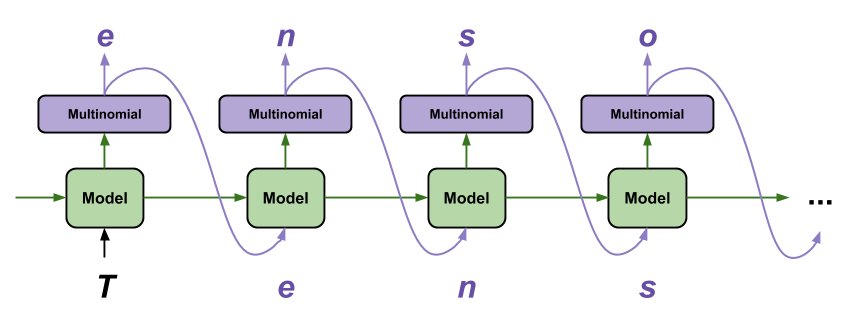

*To generate text the model's output is fed back to the input*

Every time you call the model, you input some text and the internal state. The model returns predictions for the next character and its new state. Input the predictions and state back into the model to continue generating text.

The following code generates a prediction for one step:

In [64]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it repeatedly to generate some text. Looking at the text generated, you will see that the model knows when to use capital letters, create paragraphs, and mimic Shakespearean writing style. Due to the limited number of training epochs, the model hasn't learned to form coherent sentences.

In [65]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The proudest of you anmit you to my father's heir
And not nineteen: all's many foul wrongs.
Sirrah, go to him that his soul acquaint
Is suitors his untaunt again to back my beggar:
And if thou didst love can you drink alone! 'tis not my chattes.

ROMEO:
By any but with what can damn'd this bed freely
Two of England's true-high-book prize To little in thy bridable shoe
Till death make's up his life: if he not so rise,
Devellous to beat my servant stand'd, it creating the
sense as the duke! Go take some ill visit
that your conscience and to death, with a grossly chance your meaning,
Are not thy friends the land their friends.

WARWICK:
In Gaunt, with me, I am advised;
And we will serve a lawful lady o'er his grace.

KING EDWARD IV:
You're patient when my wooul deer?

SEBASTIAN:
I thank your gates, and put us twenty our concealing eyes,
And wash me whom, and four departary here,
And make again my father obesience,
On thee before thou comest to war; but thou
since ne'er so breathe a

The easiest thing you can do to improve the results is to train it longer (try EPOCHS = 30). You can also experiment with different initial strings, try adding another RNN layer to improve model accuracy, or adjust the temperature parameter to produce predictions that are more or less random.

If you want the model to generate text faster, the easiest thing to do is to batch the text generation. In the example below, the model generates 5 outputs in almost the same time it takes to generate 1 output above.

In [66]:

start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe better.\n\nCOMINIUS:\nAy.\n\nPETRUCHIO:\nWillough.\n\nMIRANDA:\nWhere be the city I off for York!\nWhy strew my father thou! and wilt thou keep from thee,\nAnd say thou ride thy prayer seas\nShamed that good fully? I must entreat you curse\nAs thy consent and you should forget you,\nI'll not make as incastace-hearded flesh.\nWe sweeter than thou wast an womance wretch!--would tempt you from escave,\nThat, if you please to hear it all.\n\nKING HENRY VI:\nThe way not George, and Marcius brother\nAnd rivect the king King Edward's decree\nTill enge our case unto me to the senate:\nAnd, being a name, the hour, if turning thee,\nThou couldst without-too, some parder-hated from the bosom\nOf their return cry Christ is slain.\n\nLord Marquis, Sirio,\nThou know'st my heart more moved my game death!\nEarth captain, should not entreat them as thou canst,\nAs the seat o' the truth, and will report you slaughber,' dog-wink\nMy grace in some ago.\nAm crown'd, we would acqua

**Export the Generator Model**

This one-step model can easily be saved and reused, allowing you to use it wherever tf.saved_model is accepted.

In [67]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [68]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))


ROMEO:
The worthier pretty cousin; whether he was last?

KING RICHARD II:
Ray, let us have a drunk the oth


---

## **LAB ASSIGNMENT**

The training procedure in practical 2 is a simple procedure that does not give you much control. This model uses 'teacher-forcing,' which prevents bad predictions from being fed back into the model, so the model never learns to recover from mistakes. So, after you've seen how to run the model manually, you'll implement a custom training loop. This provides a starting point if, for example, you want to implement curriculum learning to help stabilize the open-loop model's output. The most crucial part of the custom training loop is the training step function.

Use `tf.GradientTape` to track gradient values. You can learn more about this approach by reading the eager execution guide.

The procedure is
- Run the model and compute the loss using tf.GradientTape.
- Calculate the updates and apply them to the model with the optimizer.

In [69]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}


The above code implements the `train_step` method according to *Keras' train_step conventions*. This is optional but allows you to modify the training step's behavior while still using Keras *Model.compile* and *Model.fit methods.*

In [71]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [72]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))


In [73]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 52ms/step - loss: 2.7140


Or, if you want to have a deeper understanding, you can create your own custom training loop:

In [74]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))


Epoch 1 Batch 0 Loss 2.1740
Epoch 1 Batch 50 Loss 2.0836
Epoch 1 Batch 100 Loss 1.9359
Epoch 1 Batch 150 Loss 1.8431

Epoch 1 Loss: 1.9850
Time taken for 1 epoch 12.89 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7869
Epoch 2 Batch 50 Loss 1.7057
Epoch 2 Batch 100 Loss 1.7111
Epoch 2 Batch 150 Loss 1.6093

Epoch 2 Loss: 1.7082
Time taken for 1 epoch 10.39 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5886
Epoch 3 Batch 50 Loss 1.5471
Epoch 3 Batch 100 Loss 1.5536
Epoch 3 Batch 150 Loss 1.5063

Epoch 3 Loss: 1.5477
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4834
Epoch 4 Batch 50 Loss 1.4515
Epoch 4 Batch 100 Loss 1.4434
Epoch 4 Batch 150 Loss 1.3952

Epoch 4 Loss: 1.4493
Time taken for 1 epoch 13.01 sec
_____________________________________________________________________

## **QUESTION**

Run the code above and state the difference with practicum 2?

The key distinction between Practicum 2 and the Lab Assignment lies in the approach to training methodologies and model checkpointing.

In Practicum 2, a more general and straightforward training approach is employed, using the `model.fit` function. Model checkpoints are stored using `tf.keras.callbacks.ModelCheckpoint`, allowing for the preservation of checkpoints during the training process.

On the other hand, the Lab Assignment implements a more specialized and intricate training approach. It involves defining the `train_step` method within the derived model, which controls the training at the batch level. Within this custom approach, explicit calculations of loss and gradients are performed using `tf.GradientTape`, and the optimizer is used to update the model weights. Model checkpoints are saved using `model.save_weights` every 5 epochs, ensuring the ability to recover training if necessary.

Furthermore, the utilization of `tf.metrics.Mean` enables the computation of the average loss during training, providing extensive control and high flexibility in training the model.

In summary, Practicum 2 employs a more general training approach with simpler methods and model checkpointing, whereas the Lab Assignment utilizes a more specialized and complex training approach, offering greater control and adaptability during the training process.